In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!nvidia-smi

Sat Mar 23 09:46:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A10G                    On  | 00000000:00:1E.0 Off |                    0 |
|  0%   17C    P8               9W / 300W |      2MiB / 23028MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Define the Autoencoder model

In [3]:
!pip install keras

In [4]:
import keras
from keras import layers

# This is our input image
input_img = keras.Input(shape=(540,))

#semi-encoded, factor 4 (540/4  ~ 140)
semi_encoded = layers.Dense(140, activation='relu')(input_img)
# "encoded" is the encoded representation of the input, factor 8 (540/8 ~ 68)
encoded = layers.Dense(68, activation='relu')(semi_encoded)

#symmetrical
semi_decoded = layers.Dense(140, activation='relu')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(540, activation='relu')(semi_decoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

2024-03-23 09:54:35.420300: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-23 09:54:36.288445: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-03-23 09:54:39.497994: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-23 09:54:45.002174: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

In [5]:
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
import keras
from keras import layers

# Define the model parameters
timesteps = 540  # Length of your sequences
input_dim = 1  # Since EDA data has a single feature
latent_dim = 68  # Same as the encoded representation in your original model

# Define the input layer
inputs = keras.Input(shape=(timesteps, input_dim))

# Encode the input sequence
encoded = layers.LSTM(latent_dim)(inputs)

# Decode the encoded sequence
decoded = layers.RepeatVector(timesteps)(encoded)
decoded = layers.LSTM(input_dim, return_sequences=True)(decoded)

# Define the autoencoder model
sequence_autoencoder = keras.Model(inputs, decoded)

# Define the encoder model
encoder = keras.Model(inputs, encoded)

In [ ]:
sequence_autoencoder.compile(optimizer='adam', loss='mse')

## TODO: Test with LSTM AutoEncoder for sequences

In [ ]:
timesteps = ...  # Length of your sequences
input_dim = ...
latent_dim = ...

inputs = keras.Input(shape=(timeste ps, input_dim))
encoded = layers.LSTM(latent_dim)(inputs)

decoded = layers.RepeatVector(timesteps)(encoded)
decoded = layers.LSTM(input_dim, return_sequences=True)(decoded)

sequence_autoencoder = keras.Model(inputs, decoded)
encoder = keras.Model(inputs, encoded)

# Import the correct Data

In [190]:
import pandas as pd
import numpy as np

# Load the normal data
# normal_dataframe = pd.read_csv('/content/drive/MyDrive/Datasets/Normal EDA/normal_eda.csv', header=None)

normal_morning = pd.read_csv('NORMAL_EDA_MORNING.csv', header=None)
fatigue_morning = pd.read_csv('FATIGUE_EDA_MORNING.csv', header=None)
normal_evening = pd.read_csv('NORMAL_EDA_EVENING.csv', header=None)
fatigue_evening = pd.read_csv('FATIGUE_EDA_EVENING.csv', header=None)

print(normal_morning[0].size)
print(normal_evening[0].size)

# Determine the minimum size of the normal and fatigue datasets
min_normal_size = min(normal_morning[0].size, normal_evening[0].size)
min_fatigue_size = min(fatigue_morning[0].size, fatigue_evening[0].size)

print(min_normal_size)

# Initialize empty dataframes for normal and fatigue datasets
normal_dataset = pd.DataFrame()
fatigue_dataset = pd.DataFrame()

#concatenate normal_evening behind normal_morning, a max of min_normal_size for each dataset into one normal_dataset
# Select the first min_normal_size rows from each dataset
normal_morning_subset = normal_morning.iloc[:min_normal_size, :]
normal_evening_subset = normal_evening.iloc[:min_normal_size, :]

fatigue_morning_subset = fatigue_morning.iloc[:min_fatigue_size, :]
fatigue_evening_subset = fatigue_evening.iloc[:min_fatigue_size, :]


# Concatenate the rows from the normal datasets
normal_dataset = pd.concat([normal_morning_subset, normal_evening_subset], ignore_index=True)
fatigue_dataset = pd.concat([fatigue_morning_subset, fatigue_evening_subset], ignore_index=True)

# Print the shapes of the normal and fatigue datasets
print("Shape of normal dataset:", normal_dataset.shape)
print("Shape of fatigue dataset:", fatigue_dataset.shape)

# Display the first 5 rows of normal and fatigue datasets with customized styling
normal_dataset.head().style.set_properties(**{'background-color': 'black',
                                              'color': 'white',
                                              'border-color': 'white'})

1019
386
386
Shape of normal dataset: (772, 480)
Shape of fatigue dataset: (1004, 480)


In [91]:
# Later, when you implement 'abnormal_dataframe', you can concatenate normal and abnormal test data
# x_test_abnormal = abnormal_dataframe
# x_test = pd.concat([x_test_normal, x_test_abnormal])
x_test = pd.concat([normal_dataset.sample(frac=0.5),fatigue_dataset.sample(frac=0.5)])


# Display training dataset head
x_test.head().style.set_properties(**{'background-color': 'black',
                                              'color': 'white',
                                              'border-color': 'white'})

# Use neurokit2 to get characteristic

In [191]:
!pip install neurokit2
!pip install torch

In [218]:
import numpy as np
import neurokit2 as nk
import torch

def extract_features(eda_signal, sampling_rate, time, label):
	# Process the raw EDA signal
	signals, info = nk.eda_process(eda_signal, sampling_rate=sampling_rate)

	# Extract clean EDA and SCR features
	cleaned = signals["EDA_Clean"]
	features = [info["SCR_Onsets"], info["SCR_Peaks"], info["SCR_Recovery"]]

	# Filter phasic and tonic components
	data = nk.eda_phasic(nk.standardize(eda_signal), sampling_rate=sampling_rate)
	phasic = data["EDA_Phasic"]
	tonic = data["EDA_Tonic"]

	# Extract desired features
	tonic_level = tonic
	phasic_level = phasic
	scr_peaks = info["SCR_Peaks"]
	scr_amplitude = info["SCR_Amplitude"]
	scr_rise_time = info["SCR_RiseTime"]

	# Initialize variables
	prev_amplitude = np.nan
	er_scr_number = 0
	peak_iterator = 0
	rise_time = 0

	features_list = []

	for i in range(len(tonic_level)):
		# Get current tonic and phasic values
		tonic = tonic_level[i]
		phasic = phasic_level[i]

		# find index of current peak
		if i == scr_peaks[peak_iterator] and peak_iterator < len(scr_peaks) - 1:
			peak_iterator += 1

		# Get current amplitude and rise time (if amp NaN, set to 1)
		amplitude = scr_amplitude[peak_iterator]
		if np.isnan(amplitude):
			amplitude = 1

		# Check if amplitude has changed and is greater than 0.3
		if prev_amplitude != amplitude and amplitude > 0.3:
			er_scr_number += 1
		prev_amplitude = amplitude

		# Get current rise time
		rise_time = scr_rise_time[peak_iterator]
		if np.isnan(rise_time):
			rise_time = 0.5

		# Append the features to the list
		features_list.append([tonic, phasic, amplitude, rise_time, er_scr_number,time,label])
		
	# Convert the features list to a PyTorch tensor
	features_tensor = torch.tensor(features_list, dtype=torch.float32)

	# print(features_list)

	return features_tensor

In [225]:
import pandas as pd
import os

# Define the CSV file path
csv_file = 'NORMAL_MORNING_EDA_FEATURES.csv'

dataset = fatigue_evening_subset

n_time = 1
n_class = 1

#transpose dataset

transposed_dataset = dataset.transpose()

# print(transposed_dataset[0])

# print(normal_dataset[0][0])

print(dataset.shape[0])

#create extracted_eda_features tensor (2 dimensions)
extracted_eda_features = torch.empty(7,0)

for i in range(dataset.shape[0]): # 772
    extracted_eda_feature = extract_features(transposed_dataset[i],4,n_time,n_class)
    
    extracted_eda_feature = torch.transpose(extracted_eda_feature,0,1) # time (0 morning) , fatigue (1 fatigue

# If extracted_eda_features is a Pandas DataFrame
    # print(extracted_eda_feature.shape[0], extracted_eda_feature.shape[1])
    # print(extracted_eda_feature)
    
    # put the extracted_feature in tensor extracted_eda_features
    extracted_eda_features = torch.cat((extracted_eda_features, extracted_eda_feature), dim=1)
    
print(extracted_eda_features.shape[0],extracted_eda_features.shape[1])

print

502
7 240960


<function print>

In [226]:
# File name
file_name = "eda_features.csv"

import numpy as np
import pandas as pd
import torch

# Assuming 'tensor' is your PyTorch tensor
tensor = extracted_eda_features  # Replace with your actual tensor

# Convert PyTorch tensor to NumPy array
numpy_array = tensor.cpu().detach().numpy()

# Convert NumPy array to pandas DataFrame
df = pd.DataFrame(numpy_array)

#transpose df

df = df.transpose()

df = df.drop(df.columns[0], axis=1)

# Append DataFrame to CSV file
df.to_csv(file_name, mode='a', header=False)


# Train model for n epochs (early stopping)


In [11]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=60,
    min_delta=0.001,
    restore_best_weights=True,
)

In [15]:
autoencoder.fit(x_train, x_train,
                epochs=2000,
                batch_size=4,
                shuffle=True,
                validation_data=(x_test_normal, x_test_normal) #it's an autoencoder, we only train on normal data
                ,callbacks=[early_stopping]
                )

Epoch 1/2000
64/64 [==============================] - 3s 13ms/step - loss: 1.3257 - val_loss: 1.5386
Epoch 2/2000
64/64 [==============================] - 0s 7ms/step - loss: 1.1542 - val_loss: 1.5120
Epoch 3/2000
64/64 [==============================] - 1s 8ms/step - loss: 1.0901 - val_loss: 1.4589
Epoch 4/2000
64/64 [==============================] - 1s 8ms/step - loss: 1.0708 - val_loss: 1.4164
Epoch 5/2000
64/64 [==============================] - 0s 7ms/step - loss: 1.1018 - val_loss: 1.4620
Epoch 6/2000
64/64 [==============================] - 0s 5ms/step - loss: 1.0562 - val_loss: 1.3786
Epoch 7/2000
64/64 [==============================] - 0s 5ms/step - loss: 1.0436 - val_loss: 1.3777
Epoch 8/2000
64/64 [==============================] - 0s 5ms/step - loss: 1.0307 - val_loss: 1.3425
Epoch 9/2000
64/64 [==============================] - 0s 4ms/step - loss: 1.0042 - val_loss: 1.2341
Epoch 10/2000
64/64 [==============================] - 0s 5ms/step - loss: 0.9305 - val_loss: 1.192

In [ ]:
sequence_autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=100,
                shuffle=True,
                validation_data=(x_test_normal, x_test_normal) #it's an autoencoder, we only train on normal data
                ,callbacks=[early_stopping]
                )

Epoch 1/100
3/3 [==============================] - 6s 846ms/step - loss: 2.2116 - val_loss: 2.6127
Epoch 2/100
3/3 [==============================] - 1s 420ms/step - loss: 1.9457 - val_loss: 2.5108
Epoch 3/100
3/3 [==============================] - 1s 412ms/step - loss: 1.8593 - val_loss: 2.4188
Epoch 4/100
3/3 [==============================] - 1s 405ms/step - loss: 1.7891 - val_loss: 2.3194
Epoch 5/100
3/3 [==============================] - 1s 396ms/step - loss: 1.7127 - val_loss: 2.2199
Epoch 6/100
3/3 [==============================] - 1s 405ms/step - loss: 1.6394 - val_loss: 2.1279
Epoch 7/100
3/3 [==============================] - 1s 402ms/step - loss: 1.5693 - val_loss: 2.0523
Epoch 8/100
3/3 [==============================] - 1s 405ms/step - loss: 1.5148 - val_loss: 1.9952
Epoch 9/100
3/3 [==============================] - 2s 716ms/step - loss: 1.4704 - val_loss: 1.9518
Epoch 10/100
3/3 [==============================] - 1s 401ms/step - loss: 1.4341 - val_loss: 1.9193
Epoch 11/

# Visualise the result

In [16]:
import matplotlib.pyplot as plt

def plot_signals(original, reconstructed, title):
    plt.figure(figsize=(12, 6))
    plt.plot(original, label='Original')
    plt.plot(reconstructed, label='Reconstructed')
    plt.legend()
    plt.title(title)
    plt.show()

12/12 [==============================] - 0s 9ms/step


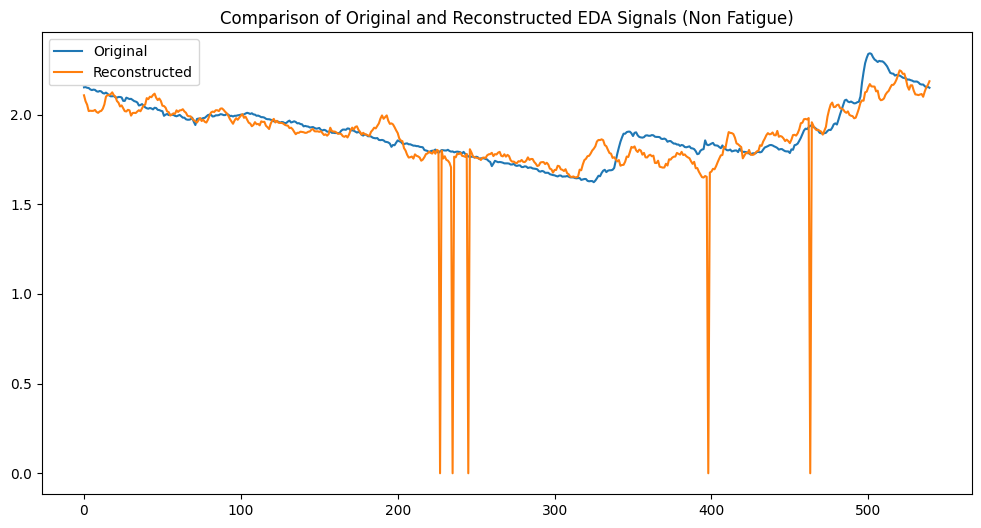

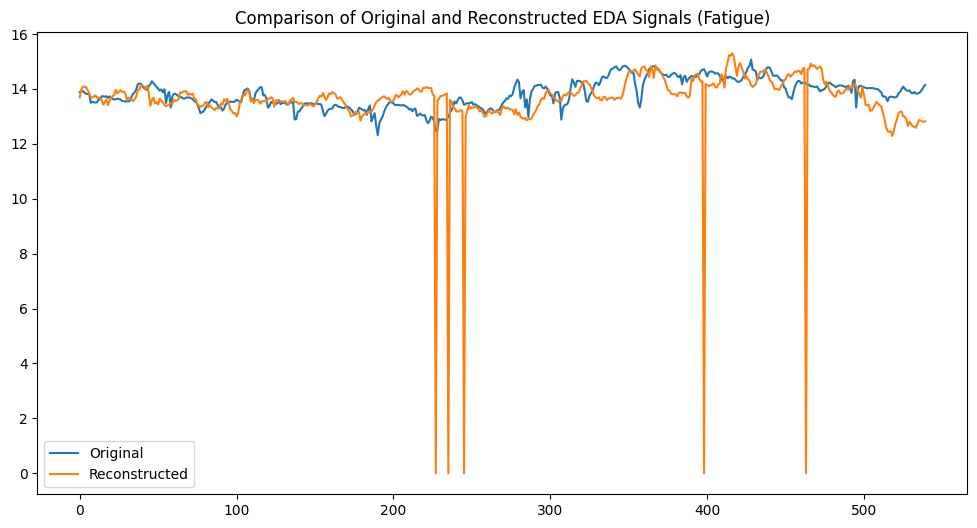

In [18]:
# Reconstruct the signals
x_test_normal_reconstructed = autoencoder.predict(x_test_normal)
x_test_abnormal_reconstructed = autoencoder.predict(x_test_abnormal)


test = 10
# Plot a sample of the original and reconstructed signals for normal signals
plot_signals(x_test_normal.iloc[test], x_test_normal_reconstructed[test], 'Comparison of Original and Reconstructed EDA Signals (Non Fatigue)')

# Plot a sample of the original and reconstructed signals for abnormal signals
plot_signals(x_test_abnormal.iloc[test], x_test_abnormal_reconstructed[test], 'Comparison of Original and Reconstructed EDA Signals (Fatigue)')



# Quantify the results

In [ ]:
import numpy as np

# Calculate Mean Squared Error (MSE) for normal signals
mse_normal = np.mean((x_test_normal - x_test_normal_reconstructed) ** 2)
print(f'Mean Squared Error (Normal): {mse_normal}')

# Calculate Mean Absolute Error (MAE) for normal signals
mae_normal = np.mean(np.abs(x_test_normal - x_test_normal_reconstructed))
print(f'Mean Absolute Error (Normal): {mae_normal}')

# Calculate Mean Squared Error (MSE) for abnormal signals
mse_abnormal = np.mean((x_test_abnormal - x_test_abnormal_reconstructed) ** 2)
print(f'Mean Squared Error (Abnormal): {mse_abnormal}')

# Calculate Mean Absolute Error (MAE) for abnormal signals
mae_abnormal = np.mean(np.abs(x_test_abnormal - x_test_abnormal_reconstructed))
print(f'Mean Absolute Error (Abnormal): {mae_abnormal}')


Mean Squared Error (Normal): 0      0.030968
1      0.016877
2      0.012057
3      0.012626
4      0.012085
         ...   
535    0.028252
536    0.031117
537    0.031974
538    0.033024
539    0.035367
Length: 540, dtype: float64
Mean Absolute Error (Normal): 0      0.100836
1      0.083462
2      0.068776
3      0.066639
4      0.067170
         ...   
535    0.084166
536    0.088298
537    0.089696
538    0.089513
539    0.093209
Length: 540, dtype: float64
Mean Squared Error (Abnormal): 0      0.479374
1      0.356712
2      0.275954
3      0.232648
4      0.217440
         ...   
535    0.221126
536    0.220476
537    0.238790
538    0.228735
539    0.213612
Length: 540, dtype: float64
Mean Absolute Error (Abnormal): 0      0.324665
1      0.286713
2      0.257203
3      0.221731
4      0.213828
         ...   
535    0.186412
536    0.201165
537    0.204616
538    0.202124
539    0.199494
Length: 540, dtype: float64


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/

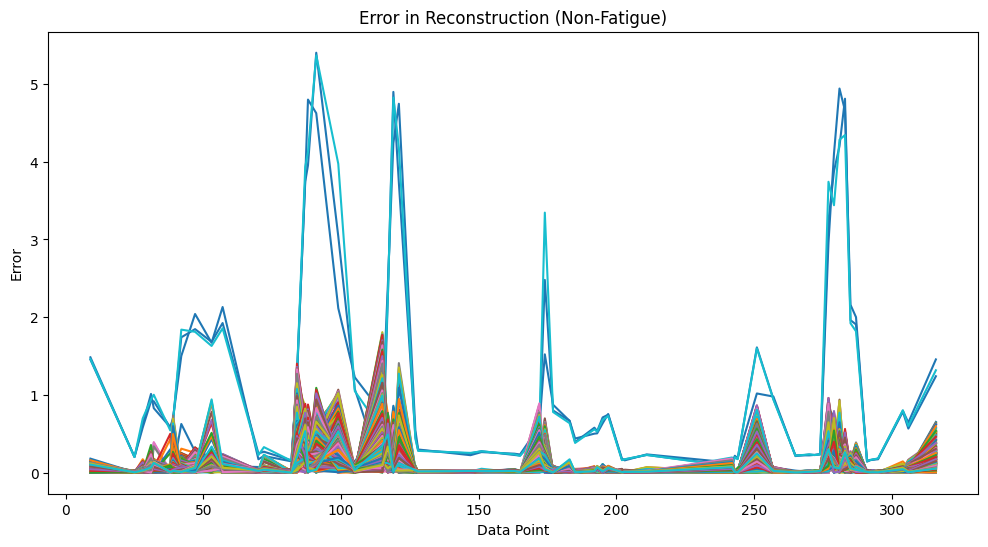

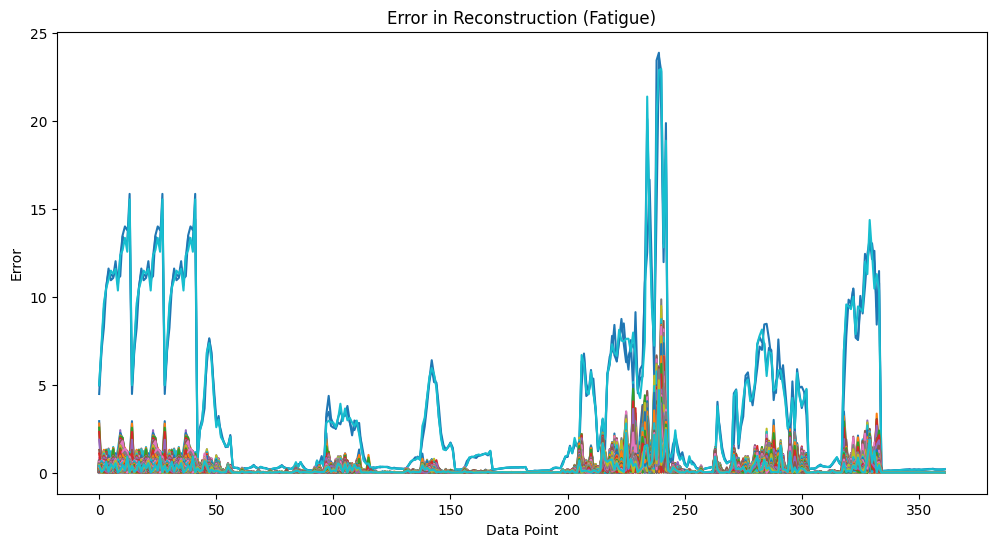

In [ ]:
import matplotlib.pyplot as plt

# Calculate the error for normal signals
error_normal = np.abs(x_test_normal - x_test_normal_reconstructed)

# Calculate the error for abnormal signals
error_abnormal = np.abs(x_test_abnormal - x_test_abnormal_reconstructed)

# Plot the error for normal signals
plt.figure(figsize=(12, 6))
plt.plot(error_normal)
plt.title('Error in Reconstruction (Non-Fatigue)')
plt.xlabel('Data Point')
plt.ylabel('Error')
plt.show()

# Plot the error for abnormal signals
plt.figure(figsize=(12, 6))
plt.plot(error_abnormal)
plt.title('Error in Reconstruction (Fatigue)')
plt.xlabel('Data Point')
plt.ylabel('Error')
plt.show()


In [ ]:
# Assuming that x_test_normal and x_test_abnormal have the same number of columns
# Create a label column for x_test_normal (not fatigued)

q_test_normal = x_test_normal
q_test_normal['label'] = 0

# Create a label column for x_test_abnormal (fatigued)
q_test_abnormal = x_test_abnormal
q_test_abnormal['label'] = 1

# Combine x_test_normal and x_test_abnormal into a single DataFrame
q_test = pd.concat([q_test_normal, q_test_abnormal])

# Reconstruct the signals for the combined test dataset
q_test_reconstructed = autoencoder.predict(q_test.drop('label', axis=1))

# Calculate the mean squared error for each sample
mse = np.mean((q_test.drop('label', axis=1) - q_test_reconstructed) ** 2, axis=1)

# Define a threshold for anomaly detection
threshold = 0.5  # You may need to adjust this value based on your data and requirements

# Classify each sample as normal or abnormal based on the MSE and threshold
q_test_reconstructed_labels = (mse > threshold).astype(int)


14/14 [==============================] - 0s 2ms/step


In [ ]:
# Define a threshold for anomaly detection
threshold = 0.5  # You may need to adjust this value based on your data and requirements

# Classify each sample as normal or abnormal based on the cosine similarity and threshold
x_test_reconstructed_labels = (similarity < threshold).astype(int)

# Convert the multilabel-indicator labels to binary labels
x_test_reconstructed_labels_binary = np.where(x_test_reconstructed_labels.sum(axis=1) > 0, 1, 0)

# Calculate the precision, recall, and F1 score for the autoencoder model
precision = precision_score(x_test['label'], x_test_reconstructed_labels_binary)
recall = recall_score(x_test['label'], x_test_reconstructed_labels_binary)
f1 = f1_score(x_test['label'], x_test_reconstructed_labels_binary)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Print the evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 score: {f1:.4f}')


Precision: 0.0000
Recall: 0.0000
F1 score: 0.0000


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate the false positive rate and true positive rate for different thresholds
fpr, tpr, thresholds = roc_curve(x_test['label'], mse)

# Calculate the area under the ROC curve
auc_value = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_value:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier baseline
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [64, 426]